## Análisis exploratorio de datos

A continuación se presenta un primer análisis basado en los datos del Censo INE 2011, publicados en la página web del Instituto.

Además se utilizan varios conjuntos de datos disponibilizados en la web. Se realizó un pre-procesamiento para seleccionar variables relevantes, reduciendo el volúmen de datos y por tanto los requerimientos informáticos para su acceso.

La base de personas del Censo INE 2011 se filtra según el siguiente criterio:
- Variable "PERMI07" (lugar de residencia 5 años antes) con valores:
    - 3 = en otro departamento
    
Se excluyen habitantes de localidades rurales.

La tabla resultante contiene un departamento de origen, uno de destino y una cantidad de personas que declaran haber vivido antes en el departamento de "origen", habiendo sido relevadas en el departamento de "destino" al momento de la aplicación del formulario censal.

### El perfil de la migración interna

En el apartado 2.4, referido a los antecedentes del estudio de la migración interna en Uruguay, ya se puntualizaban algunas características de la población migrante interna:

- el perfil más joven y feminizado de quienes migran hacia Montevideo.

- el perfil de familias completas, integradas por parejas de entre 30 y 40 años con niños, de quienes migran desde Montevideo.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import numpy as np

from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))
    
# funciones desarrolladas
from functions.agrupar_dfs_censo import *
from functions.graficas import get_bottoms
from functions.cargar_data import cargar_data_eda
from functions.func_demograficas import indice_mascul, porcentaje_sexo

metadatos_figs = {'Author': '''Guillermo D'Angelo'''}

In [2]:
# carga datos
censo, pbi, md = cargar_data_eda()

#### Reclasificaciones de las variables de educación

In [3]:
def reclas_edu_censo(df, old_var, new_var):
    "Reclasifica variables de educación en el Censo INE 2011"
    df.loc[df[old_var].between(1, 3),   new_var] = 1
    df.loc[df[old_var].between(4, 5),   new_var] = 2
    df.loc[df[old_var].between(6, 7),   new_var] = 3
    df.loc[df[old_var].between(8, 10),  new_var] = 4
    df.loc[df[old_var].between(11, 12), new_var] = 5
    return df

censo = reclas_edu_censo(censo, 'PERED03_R', 'PERED03_R_reclass')

# cat 1: Preescolar, Primaria común. Primaria especial
# cat 2: Ciclo Básico Liceo (1ero a 3ro), Ciclo Básico UTU (1ero a 3ro)
# cat 3: Bachillerato Secundario (4to a 6to), Bachillerato UTU (4to a 6to)
# cat 4: Enseñanza Técnica/Formación Profesional UTU, Magisterio o Profesorado, Terciario no universitario
# cat 5: Universidad o Instituto Universitario (Carrera de grado o Licenciatura), Posgrado (Diploma/Maestría/Doctorado)

# para verificar
# pd.DataFrame(censo.groupby(['PERED03_R', 'PERED03_R_reclass']).size()).reset_index()

# completa los valores faltantes (88) de la variable PERED03_1 con los 
# de la variable PERED03_2... Ésta última serían datos relevados en planillas (papel?)
censo.loc[(censo.PERED03_1 == 88), 'PERED03_1'] = censo.PERED03_2

# reclasifica
censo = reclas_edu_censo(censo, 'PERED03_1', 'PERED03_1_reclass')

# verifica
# pd.DataFrame(censo.groupby(['PERED03_1', 'PERED03_1_reclass']).size()).reset_index()

In [4]:
def filter_df_censo(df):
    # un primer análisis abarcando sólo aquellas personas que han migrado entre departamentos
    # (no toma en cuenta quienes han migrado otras localidades dentro del mismo departamento)
    mgr = df.loc[df.PERMI07 == 3].reset_index(drop=True)
    # identifica depto de residencia anterior, creando var "depto_origen"
    mgr.insert(0, 'depto_origen', mgr.loc[:,('PERMI07_2')])
    # convierte a integer
    mgr.loc[:,('depto_origen')] = mgr.loc[:,('depto_origen')].astype(int)
    # renombra DPTO
    mgr.rename(columns={'DPTO': 'depto_destino'}, inplace=True)

    return mgr

In [5]:
mgr_interdep = filter_df_censo(censo)
mgr_interdep.shape[0]

148759

#### Genera tres data frames con:
- Migrantes de interior a Montevideo (A)
- Migrantes de Montevideo a interior (B)
- Migrantes entres deptos del interior (C)

In [6]:
# genera dataframes por tipología
def filter_df_mig(df, ver_dep_ori, var_dep_des):
    "Corta DFs según origen y destino de la migración"
    # destino Mvdeo.
    a = df[df[var_dep_des] == 1].reset_index()
    # origen Mvdeo. y destino no Mvdeo.
    b = df[(df[ver_dep_ori] == 1) & (df[var_dep_des] != 1)].reset_index()
    # origen y destino no Mvdeo.
    c = df[(df[ver_dep_ori] != 1) & (df[var_dep_des] != 1)].reset_index()
    
    return a, b, c

# aplica función
a, b, c = filter_df_mig(mgr_interdep, 'depto_origen', 'depto_destino')

# enlista los tres DFs
lista_dfs = [a, b, c]

# enlista junto con el censo
lista_dfs_censo = [censo, a, b, c]

print(a.shape, b.shape, c.shape)

(42444, 52) (58655, 52) (47660, 52)


In [7]:
# cantidad de personas
print('n de migrantes internos: ', mgr_interdep.shape[0])
print('n de migrantes con origen interior y destino Montevideo: ', a.shape[0])
print('n de migrantes con origen Montevideo y destino Interior: ', b.shape[0])
print('n de migrantes con origen Interior y destino Interior: ', c.shape[0])

n de migrantes internos:  148759
n de migrantes con origen interior y destino Montevideo:  42444
n de migrantes con origen Montevideo y destino Interior:  58655
n de migrantes con origen Interior y destino Interior:  47660


#### Índice de masculinidad

In [8]:
# Índice de masculinidad
help(indice_mascul)

Help on function indice_mascul in module functions.func_demograficas:

indice_mascul(df, var_sexo, redondeo)
    Calcula el índice de masculinidad sobre datos de personas del Censo INE 2011



In [9]:
# índice de masculinidad para todo el país
ind_m_pais = indice_mascul(censo, 'PERPH02', 1)

# índice de masculinidad para migrantes recientes que migran hacia Mvdeo.
ind_m_desagregado = [indice_mascul(x, 'PERPH02', 1) for x in lista_dfs]

printmd("""
El índice de masculinidad para migrantes recientes
**hacia Montevideo** es de **{}**, para migrantes **desde Montevideo hacia el interior** es de **{}**
en tanto que para migrantes **entre departamentos del interior** es de **{}** hombres por cada 100 mujeres.
""".format(ind_m_desagregado[0], ind_m_desagregado[1], ind_m_desagregado[2])
       )

printmd("El índice de masculinidad para el total de la población es de **{}** hombres por cada 100 mujeres.".format(ind_m_pais))


El índice de masculinidad para migrantes recientes
**hacia Montevideo** es de **80.0**, para migrantes **desde Montevideo hacia el interior** es de **92.4**
en tanto que para migrantes **entre departamentos del interior** es de **102.2** hombres por cada 100 mujeres.


El índice de masculinidad para el total de la población es de **92.3** hombres por cada 100 mujeres.

In [10]:
# setea tipo de fuente y tamaño
size = 9
font = {'fontname': 'Arial', 'fontsize': size}

# fuente de leyendas
font_legend = font_manager.FontProperties(family='Arial', style='normal', size=10)

In [11]:
# tamaño de las gráficas (pulgadas)
fig_size = [4, 2.4]

In [12]:
# ancho de las barras
bars_width=0.40

# colores
color = 'darkcyan'
color_spines = 'grey'

# etiquetas
labels = ['Hacia \n Montevideo',
          'Desde Montevideo\n al interior',
          'Entre deptos.\n del interior']

def format_spines(color):
    "Formatea spines"
    # oculta ejes superior y derecho
    [ax.spines[x].set_visible(False) for x in ["top", "right"]]
    # color de ejes inferior e izquierdo
    [ax.spines[x].set_color(color) for x in ["bottom", "left"]]

def format_ticks(labels, color, ind):
    "Formatea ticks y etiquetas"
    plt.xticks(ind, labels=labels, **font, color=color)
    plt.yticks(**font, color=color)
    plt.tick_params(axis='y',color=color)
    plt.tick_params(axis='x', bottom=False, labelbottom=True, color=color) 

def save_chart(name):
    plt.savefig('mapas_graficas/' + name,
                 bbox_inches= 'tight',
                 metadata= metadatos_figs)

In [13]:
def plot_tres_barras(datos_dfs, dato_censo, ylim, sep, filename):
    "Grafica tres barras y dato del censo, exporta a pdf"
    # grafica edades medianas
    fig, ax = plt.subplots(figsize = fig_size)
    # n de barras
    ind=np.arange(3)
    # ancho de las barras
    bars_width=0.40
    # límite en eje Y
    plt.ylim(0, ylim)
    # controla el intervalo de etiquetas en los ticks del eje Y
    plt.yticks(np.arange(0, ylim + 0.1, sep))
    # plotea
    [plt.bar(i, datos_dfs[i],  width=bars_width, color=color, label=labels[i]) for i in range(3)]
    # spines
    [ax.spines[x].set_visible(False) for x in ["top", "right"]]
    [ax.spines[x].set_color(color_spines) for x in ["bottom", "left"]]
    # formato etiquetas
    format_ticks(labels, color_spines, ind)
    # línea de dato país
    plt.axhline(dato_censo, color='k')
    # agrega texto sobre el valor para todo el país
    ax.text(-0.2, dato_censo * 1.05, 'Valor para el país', **font)
    # exporta
    save_chart(filename + '.pdf')
    # muestra
    plt.show()

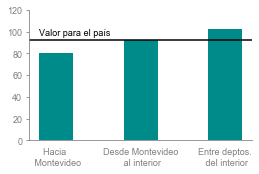

In [14]:
plot_tres_barras(ind_m_desagregado, ind_m_pais, 120, 20, 'eda_001_barras_masculinidad')

In [15]:
# proporción varones/mujeres
help(porcentaje_sexo)

# aplica función para lista extendida de DFs
prop_sexo_dfs = [porcentaje_sexo(x, 'PERPH02') for x in lista_dfs_censo]

# traspone las listas
prop_sexo_tranposed = [[h,i,j,k] for h,i,j,k in zip(*prop_sexo_dfs)]

Help on function porcentaje_sexo in module functions.func_demograficas:

porcentaje_sexo(df, var_sexo)
    Calcula el porcentaje por sexo de un dataframe



In [16]:
# etiquetas a ser utilizadas
labels_extended = ['Total país',
                   'Hacia\n Montevideo',
                   'Desde Mvdeo.\n al interior',
                   'Entre dptos.\n del interior']

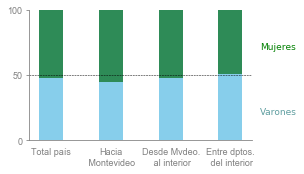

In [17]:
fig, ax = plt.subplots(figsize=fig_size)

# setea paleta de colores
colors = 'skyblue', 'seagreen'

# mínimo y máximo de ejes
plt.ylim(0, 100)

# controla el intervalo de etiquetas en los ticks del eje Y
plt.yticks(np.arange(0, 101, 50))

# n de barras
ind=np.arange(4)

# línea del 50%
plt.axhline(50, color='k', linewidth=0.5, linestyle='--')

_bottoms = [None, prop_sexo_tranposed[0]]

# grafica
p = [plt.bar(ind, prop_sexo_tranposed[i], width=bars_width, bottom=_bottoms[i], color=colors[i]) for i in range(2)]

format_spines(color_spines)
format_ticks(labels_extended, color_spines, ind)

def etiquetar_sexos_barras(x_position, ax_name, colors, font_size):
        # Varones
        ax_name.text(x_position, 20, 'Varones',
        horizontalalignment='left',
        color=colors[0], fontsize=font_size)
        # Mujeres
        ax_name.text(x_position, 70, 'Mujeres',
        horizontalalignment='left',
        color=colors[1], fontsize=font_size)

etiquetar_sexos_barras(3.5, plt, ['cadetblue', 'green'], 9)
        
save_chart('eda_002_porcentaje_sexo.pdf')

plt.show()

#### Edades medianas

In [18]:
# edades medianas
emed = [x.PERNA01.median().astype(int) for x in lista_dfs]
e_med_censo = censo.PERNA01.median().astype(int)

printmd("""Las edades medianas son **{}**, **{}** y **{}** años respectivamente. En tanto el valor para el país es de **{}**.
""".format(emed[0], emed[1], emed[2], e_med_censo))

Las edades medianas son **23**, **32** y **28** años respectivamente. En tanto el valor para el país es de **34**.


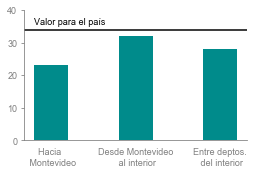

In [19]:
plot_tres_barras(emed, e_med_censo, 40, 10, 'eda_003_edades_medianas')

## Distribución por edades

#### Distribución por grupos de edad

In [20]:
# define paleta de colores
rosado  = (0.90, 0.40, 0.56)
violeta = (0.31, 0.11, 0.45)
salmon  = (0.98, 0.80, 0.67)
fucsia  = (0.72, 0.20, 0.58)
oscuro  = (0.08, 0.02, 0.13)
lista_colores = rosado, violeta, salmon, fucsia, oscuro

In [21]:
# GRUPOS DE 0 a 3 años', '4 a 17 años', '18 a 64 años', '65 o más años'
grupos_edad = [grupos_de_edad(x, 'PERNA01')  for x in lista_dfs_censo]

# traspone las series enlistada y las devuelve en una lista 
grupos_edad_t = [[h,i,j,k] for h,i,j,k in zip(*grupos_edad)]

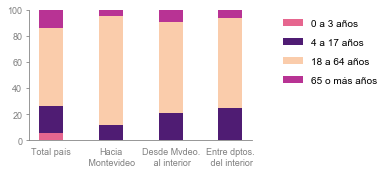

In [22]:
fig, ax = plt.subplots(figsize = fig_size)

# n de barras
ind = np.arange(4)

# setea paleta de colores
colors = lista_colores

# mínimo y máximo de ejes
plt.ylim(0, 100)

# enlista los fondos calculados con la función get_bottoms
_bottoms = get_bottoms(grupos_edad_t)

# grafica
p = [plt.bar(ind, grupos_edad_t[i], width=bars_width, color=colors[i], bottom=_bottoms[i]) for i in range(4)]

format_spines(color_spines)
format_ticks(labels_extended, color_spines, ind)

_labels = ['0 a 3 años',
           '4 a 17 años',
           '18 a 64 años',
           '65 o más años']

# leyenda
def format_legend(x_position, labels):
    plt.legend(p,
               labels,
               bbox_to_anchor=(x_position, 1),
               loc='upper right',
               frameon=False,
               labelspacing=1,
               prop=font_legend)

format_legend(1.60, _labels)

save_chart('eda_004_dist_grupos_edad.pdf')

plt.show()

In [23]:
# agrupa datos
edades_censo = agrupar_por_edades(censo, 'PERNA01')
edades = [agrupar_por_edades(x, 'PERNA01') for x in lista_dfs]

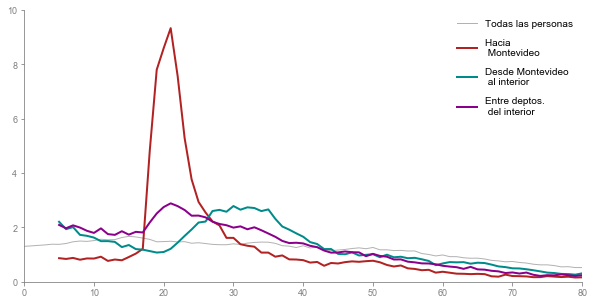

In [24]:
# ploteo de edades
fig, ax = plt.subplots(figsize=(10, 5))

# plote líne con valores para todas las personas
plt.plot(edades_censo.edad,
         edades_censo.porc_pers,
         label='Todas las personas',
         linewidth=1,
         color='grey',
         alpha=0.6)

# plotea las otras tres distribuciones
colors = ['firebrick', 'darkcyan', 'darkmagenta']

[plt.plot(edades[i].edad, edades[i].porc_pers, color=colors[i], label=labels[i], linewidth=2) for i in range(3)]


plt.legend(loc='upper right',
           frameon=False,
           labelspacing=1,
           prop=font_legend)

# setea límites de ejex x e y
plt.ylim(0, 10)
plt.xlim(0, 80)

plt.xticks(**font, color=color_spines)
plt.yticks(**font, color=color_spines)
plt.tick_params(axis='y', color=color_spines)
plt.tick_params(axis='x', labelbottom=True, color=color_spines) 

format_spines(color_spines)

save_chart('eda_006_distribucion_edades.pdf')

plt.show()

## **Hogares**

In [25]:
def promedio_integrantes(df_censo, viviendas_col):
    "Calcula promedio de integrantes del hogar"
    cols = ['HOGCOD', 'DPTO', 'PERMI07', 'PERMI07_2']
    
    if viviendas_col == True:
        df = df_censo.loc[:,cols]
    elif viviendas_col == False:
        df = df_censo.loc[df_censo.TIPO_VIVIE==1,cols]
    else:
        raise Exception('viviendas_col acepta solo valores True o False')

    lista_vars = ['total', 'ori_mvo', 'des_mvo', 'des_int']
        
    df[lista_vars[0]] = 1
    [df.insert(len(df.columns), lista_vars[i], 0) for i in range(1,4)]

    # destino Mvdeo.
    df.loc[(df.PERMI07 == 3) & (df.DPTO==1), lista_vars[1]] = 1
    # destino interior
    df.loc[(df.PERMI07 == 3) & (df.PERMI07_2== 1), lista_vars[2]] = 1
    # entre interior
    df.loc[(df.PERMI07 == 3) & (df.PERMI07_2!=1) & (df.DPTO!=1) & (df.PERMI07_2.isnull()==False), lista_vars[3]] = 1

    df_group = df.groupby('HOGCOD').agg(
        {   lista_vars[0]: sum,
            lista_vars[1]: sum,
            lista_vars[2]: sum,
            lista_vars[3]: sum
        })

    means = [df_group.loc[df_group[i]>0, lista_vars[0]].mean().round(2) for i in lista_vars]

    return means

In [26]:
promedio_integrantes(censo, viviendas_col=False)

[2.79, 2.55, 3.04, 3.2]

In [27]:
promedio_integrantes(censo, viviendas_col=True)

[2.82, 2.69, 3.07, 3.24]

In [28]:
# edades medianas
prom_hog = promedio_integrantes(censo, True)

printmd("""El promedio de integrantes por hogar es de **{}**, **{}** y **{}** personas respectivamente; en tanto el valor para el país es de **{}**.
""".format(prom_hog[1], prom_hog[2], prom_hog[3], prom_hog[0]))

El promedio de integrantes por hogar es de **2.69**, **3.07** y **3.24** personas respectivamente; en tanto el valor para el país es de **2.82**.


In [29]:
# plot_tres_barras(prom_hog[1:4], prom_hog[0], 4, 1, 'eda_014_promedio_personas_hogar.pdf')

In [30]:
# edades medianas
prom_hog_nocol = promedio_integrantes(censo, False)

printmd("""El promedio de integrantes por hogar excluyendo hogares colectivos es de **{}**, **{}** y **{}** personas respectivamente; en tanto el valor para el país es de **{}**.
""".format(prom_hog_nocol[1], prom_hog_nocol[2], prom_hog_nocol[3], prom_hog_nocol[0]))

El promedio de integrantes por hogar excluyendo hogares colectivos es de **2.55**, **3.04** y **3.2** personas respectivamente; en tanto el valor para el país es de **2.79**.


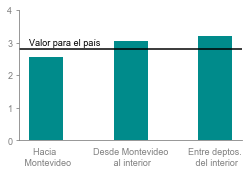

In [31]:
plot_tres_barras(prom_hog_nocol[1:4], prom_hog_nocol[0], 4, 1, 'eda_015_promedio_personas_hogar_sin_hogcol.pdf')

#### Viviendas colectivas

In [32]:
# calcula porcentaje de personas viviendo en viviendas colectivas sobre el total de personas
viv_col = [(x.groupby('TIPO_VIVIE').size()[2]/x.shape[0]*100).round(2) for x in lista_dfs_censo]

printmd("""El porcentaje de personas que viven en viviendas colectivas es de **{} %**, **{} %** y **{} %**; en tanto el valor para el país es de **{} %**.
""".format(viv_col[1], viv_col[2], viv_col[3], viv_col[0]))

El porcentaje de personas que viven en viviendas colectivas es de **6.84 %**, **0.71 %** y **2.3 %**; en tanto el valor para el país es de **1.17 %**.


In [33]:
def plot_tres_barras_custom(datos_dfs, dato_censo, ylim, sep, dato_censo_x, dato_censo_y, filename):
    "Grafica tres barras y dato del censo, exporta a pdf"
    # grafica edades medianas
    fig, ax = plt.subplots(figsize = fig_size)
    # n de barras
    ind=np.arange(3)
    # ancho de las barras
    bars_width=0.40
    # límite en eje Y
    plt.ylim(0, ylim)
    # controla el intervalo de etiquetas en los ticks del eje Y
    plt.yticks(np.arange(0, ylim + 0.1, sep))
    # plotea
    [plt.bar(i, datos_dfs[i],  width=bars_width, color=color, label=labels[i]) for i in range(3)]
    # spines
    [ax.spines[x].set_visible(False) for x in ["top", "right"]]
    [ax.spines[x].set_color(color_spines) for x in ["bottom", "left"]]
    # formato etiquetas
    format_ticks(labels, color_spines, ind)
    # línea de dato país
    plt.axhline(dato_censo, color='k')
    # agrega texto sobre el valor para todo el país
    ax.text(dato_censo_x, dato_censo * dato_censo_y, 'Valor para el país', **font)
    # exporta
    save_chart(filename + '.pdf')
    # muestra
    plt.show()

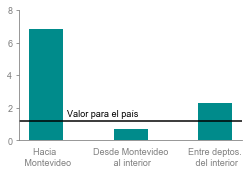

In [34]:
plot_tres_barras_custom(viv_col[1:4], viv_col[0], 8, 2, 0.25, 1.25,'eda_016_porcent_viviendas_colectivas.pdf')

#### Presencia de niños en hogares

In [35]:
censo.head()

,DPTO,LOC,SECC,SEGM,VIVID,TIPO_VIVIE,HOGCOD,HOGID,PERPH02,PERPA01,...,PERED03_2,PERED04_R,PERED05_R,PERED06_R,CODIGO_CAR,PERED08,NIVELEDU_R,PERED03_R_reclass,PERED03_1_reclass,grupo_edad
0,1,20,1,1,3,1,102001001000301,1,2,11,...,0,1,3,0,22101,1,4,NaN,2.0,3.0
1,1,20,1,1,3,1,102001001000301,1,2,1,...,0,2,2,0,11101,2,2,NaN,1.0,4.0
2,1,20,1,1,3,1,102001001000301,1,1,13,...,0,2,0,0,22101,1,4,NaN,2.0,3.0
3,1,20,1,1,3,1,102001001000301,1,2,12,...,0,0,0,0,101,0,0,NaN,NaN,1.0
4,1,20,1,1,5,1,102001001000501,1,2,1,...,0,0,5,4,55138,1,9,5.0,NaN,3.0


In [114]:
cols = ['HOGCOD', 'DPTO', 'PERMI07', 'PERMI07_2', 'PERNA01']    
df = censo.loc[:,cols]

lista_vars = ['total', 'ori_mvo', 'des_mvo', 'des_int', '0a10', '11a17']

df[lista_vars[0]] = 1
[df.insert(len(df.columns), lista_vars[i], 0) for i in range(1,6)]

# destino Mvdeo.
df.loc[(df.PERMI07 == 3) & (df.DPTO==1), lista_vars[1]] = 1
# destino interior
df.loc[(df.PERMI07 == 3) & (df.PERMI07_2== 1), lista_vars[2]] = 1
# entre interior
df.loc[(df.PERMI07 == 3) & (df.PERMI07_2!=1) & (df.DPTO!=1) & (df.PERMI07_2.isnull()==False), lista_vars[3]] = 1

# niños
df.loc[(df.PERNA01.between(0,10)), lista_vars[4]] = 1
df.loc[(df.PERNA01.between(11,17)), lista_vars[5]] = 1

df_group = df.groupby('HOGCOD').agg(
            {   lista_vars[0]: sum,
                lista_vars[1]: sum,
                lista_vars[2]: sum,
                lista_vars[3]: sum,
                lista_vars[4]: sum,
                lista_vars[5]: sum
            })


df.head()

,HOGCOD,DPTO,PERMI07,PERMI07_2,PERNA01,total,ori_mvo,des_mvo,des_int,0a10,11a17
0,102001001000301,1,0,NaN,22.0,1,0,0,0,0,0
1,102001001000301,1,0,NaN,84.0,1,0,0,0,0,0
2,102001001000301,1,0,NaN,21.0,1,0,0,0,0,0
3,102001001000301,1,0,NaN,0.0,1,0,0,0,1,0
4,102001001000501,1,0,NaN,31.0,1,0,0,0,0,0


In [116]:
cross = pd.crosstab(index=[df.ori_mvo, df.des_mvo, df.des_int], columns=[df['0a10'], df['11a17']])

# cross.reset_index(inplace=True)

# df_cross = pd.DataFrame(cross.values[1:4,3:6])

# df_cross.set_index(pd.Series(['ori_mvo', 'des_mvo', 'des_int']), inplace=True)
# df_cross.columns = ['0a3', '4a10', '11a17']

cross

# algo mal hay



0a10                           0               1
11a17                          0       1       0
ori_mvo des_mvo des_int                         
0       0       0        2288836  354431  493851
                1          35981    6051    5628
        1       0          46526    5558    6571
1       0       0          37529    2743    2172

In [117]:
df_cross = cross.reset_index()

df_cross = pd.DataFrame(df_cross.values[1:4,4:7])

df_cross.set_index(pd.Series(['des_int', 'des_mvo', 'ori_mvo']), inplace=True)
df_cross.columns = ['11a17', '0a10']

df_cross


,11a17,0a10
des_int,6051,5628
des_mvo,5558,6571
ori_mvo,2743,2172


In [122]:
df.loc[(df['des_int']>0) & (df['0a10']>0), '0a10'].sum()

5628

## **Educación**

In [ ]:
def get_edu_asist(df, var_edu):
    "Calcula los porcentajes de personas que asisten a centros educativos"
    df_filtered = df.loc[df[var_edu].between(1, 4), var_edu]
    values = df_filtered.value_counts(normalize=True,sort=False).mul(100)
    
    return values

In [ ]:
# aplica a la lista de 4 DFs
edu_asist = [get_edu_asist(x, 'PERED01') for x in lista_dfs_censo]

# traspone las series enlistada y las devuelve en una lista 
edu_asist_list = [[h,i,j,k] for h,i,j,k in zip(*edu_asist)]

In [ ]:
fig, ax = plt.subplots()

# n de barras
ind = np.arange(4)

# setea paleta de colores
colors = rosado, violeta, salmon, 'silver'

# mínimo y máximo de ejes
plt.ylim(0, 100)

# enlista los fondos calculados con la función get_bottoms
_bottoms = get_bottoms(edu_asist_list)

# grafica
p = [plt.bar(ind, edu_asist_list[i], width=bars_width, color=colors[i], bottom=_bottoms[i]) for i in range(4)]

# oculta spines
format_spines(color_spines)

# labels
plt.xticks(ind, labels_extended)

_labels = ['Sí, a un establecimiento público',
           'Sí, a un establecimiento privado',
           'No asiste pero asistió',
           'Nunca asistió']

# oculta ticks en eje x
plt.tick_params(axis='x', bottom=False, labelbottom=True) 

# leyenda
plt.legend((p[0], p[1], p[2], p[3]),
           _labels,
           bbox_to_anchor=(1.65, 1),
           loc='upper right',
           frameon=False,
           labelspacing=1,
           prop=font_legend)

format_ticks(labels_extended, color_spines, ind)

save_chart('eda_007_asistencia_educacion.pdf')

plt.show()

#### **Nivel educativo que cursa actualmente**

In [ ]:
edunivel = [x.PERED03_R_reclass.value_counts(normalize=True,sort=False).mul(100).sort_index() for x in lista_dfs_censo]

# enlista
edunivel_list = [[h,i,j,k] for h,i,j,k in zip(*edunivel)]

In [ ]:
fig, ax = plt.subplots()

# ubicación de los grupos
ind = np.arange(4)

# mínimo y máximo de ejes
plt.ylim(0, 100)

# setea paleta de colores
colors = lista_colores

# pairwise sum para completar los "bottom"
_bottoms = get_bottoms(edunivel_list)

# grafica
p = [plt.bar(ind, edunivel_list[i], width=bars_width, color=colors[i], bottom=_bottoms[i]) for i in range(5)]

format_spines(color_spines)

# labels
plt.xticks(ind, labels_extended)

_labels = ['Primaria o prescolar',
           'Ciclo básico (liceo o UTU)',
           'Bachillerato (liceo o UTU)',
           'Terciario no universitario',
           'Universitario (grado o posgrado)']

# oculta ticks
format_ticks(labels_extended, color_spines, ind)

# leyenda
plt.legend((p[0], p[1], p[2], p[3], p[4]),
           _labels,
           bbox_to_anchor=(1.65, 1),
           loc='upper right',
           frameon=False,
           labelspacing=1,
           prop=font_legend)

save_chart('eda_008_nivel_educativo_actual.pdf')

plt.show()

#### **Nivel más alto cursado**

In [ ]:
max_edunivel = [x.PERED03_1_reclass.value_counts(normalize=True,sort=False).mul(100).sort_index()  for x in lista_dfs_censo]

# enlista
max_edunivel_list = [[h,i,j,k] for h,i,j,k in zip(*max_edunivel)]

In [ ]:
fig, ax = plt.subplots()

ind = np.arange(4)

# pairwise sum para completar los "bottom"
_bottoms = get_bottoms(max_edunivel_list)

# mínimo y máximo de ejes
plt.ylim(0, 100)

# grafica
p = [plt.bar(ind, max_edunivel_list[i], width=bars_width, color=colors[i], bottom=_bottoms[i]) for i in range(5)]

# oculta spines
format_spines(color_spines)

# oculta ticks en eje x
format_ticks(labels_extended, color_spines, ind)

# leyenda
plt.legend((p),
           _labels,
           bbox_to_anchor=(1.65, 1),
           loc='upper right',
           frameon=False,
           labelspacing=1,
           prop=font_legend)

save_chart('eda_009_nivel_mas_alto_alcanzado.pdf')


plt.show()

## más cosas para ver:
- relación entre sexo y distancia de lamigración
- caracterizar hogares migrantes (cantidad de niños, edades promedio)